# Yale Hydropower Model

## Rocky River Powerplant

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import datetime, calendar
import random

In [2]:
# Load data
stream_flow_data_path = './data/StreamFlowData.csv'
stream_flow_df = pd.read_csv(stream_flow_data_path)
stream_flow_df = stream_flow_df.drop(['Unnamed: 0', 'agency_cd', 'site_no', 'X_00060_00003_cd'], axis=1)
stream_flow_df = stream_flow_df.rename(columns={"Date":"Date", "X_00060_00003":"CFS"})
stream_flow_df['Date'] = pd.to_datetime(stream_flow_df['Date'], format='%m/%d/%Y')

# Filter out 1993-2021
df_stream = stream_flow_df[(stream_flow_df['Date'] >= '1993-01-01') & (stream_flow_df['Date'] < '2022-01-01')]
df_stream = df_stream[~((df_stream.Date.dt.month == 2) & (df_stream.Date.dt.day == 29))]

In [3]:
# df_stream = df_stream.set_index('Date')
CFS = list(df_stream['CFS'])
Dates = list(df_stream['Date'])

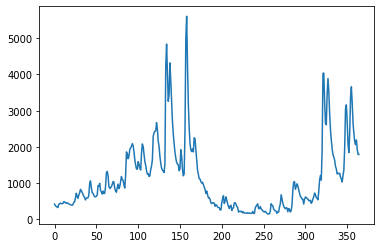

In [4]:
# Plot total CFS for any given year (year_offset)
x_temp = np.arange(0, 365, 1)
year_offset = 9
plt.plot(x_temp, CFS[365 * year_offset:365 + 365 * year_offset])

In [5]:
# Finds local minima (baseline)
def find_minima(s):
    n = len(s)
    minima_loc = [0]
    for i in range(1, n - 1):
        if s[i] <= s[i - 1] and s[i] <= s[i + 1]:
            minima_loc.append(i)
    minima_loc.append(n-1)
    return minima_loc

# Returns baseline function
def interpolate_minima(s, minima):
    new_s = []
    for i in range(len(minima) - 1):
        diff = s[minima[i + 1]] - s[minima[i]]
        interval = diff / (minima[i + 1] - minima[i])
        for j in range(minima[i + 1] - minima[i]):
            new_s.append(s[minima[i]] + j * interval)
    new_s.append(s[-1])
    return new_s

In [6]:
CFS_minima = find_minima(CFS)
CFS_interpolated = interpolate_minima(CFS, CFS_minima)
CFS_years = []
CFS_interpolated_years = []
CFS_net_years = []

counter = 0
base_year = 1993
year_nums = []

for i in range(int(len(CFS) / 365)):
    year = []
    year_interp = []
    net_flow = 0
    
    for j in range(365):
        year.append(CFS[counter])
        year_interp.append(CFS_interpolated[counter])
        net_flow += CFS[counter]
        counter += 1
        
    CFS_years.append(year)
    CFS_interpolated_years.append(year_interp)
    CFS_net_years.append(net_flow)
    year_nums.append(base_year + i)

In [7]:
sf_data = []
for i, y in enumerate(year_nums):
    sf_data.append((y, CFS_net_years[i], CFS_years[i], CFS_interpolated_years[i]))
    
sorted_data = sorted(sf_data, key=lambda x: x[1], reverse=True)

In [8]:
# Print out lowest and highest quartile of years in terms of total CFS 

print(len(sorted_data))
Q1 = []
Q4 = []

for i in range(8):
    Q1.append(sorted_data[-(i + 1)])
    Q4.append(sorted_data[i])

print("\nQ1")
for i in range(8):
    print(Q1[i][0], Q1[i][1])

print("\nQ4")
for i in range(8):
    print(Q4[i][0], Q4[i][1])

29

Q1
2016 373789.0
2002 411245.0
2012 476177.0
2015 498124.0
2001 502345.0
1995 519831.0
2020 522484.0
2017 526530.0

Q4
2011 1122488.0
1996 1037640.0
2018 989207.0
2008 953990.0
2021 874727.0
2003 870683.0
2005 853226.0
2006 841289.0


In [9]:
Q1_ave_baseflow = []
Q1_min_baseflow = []
Q1_max_baseflow = []
Q4_ave_baseflow = []
Q4_min_baseflow = []
Q4_max_baseflow = []

for d in range(365):
    Q1_ave = 0.0
    Q4_ave = 0.0
    for y in range(8):
        Q1_ave += Q1[y][3][d]
        Q4_ave += Q4[y][3][d]
        
    Q1_ave_baseflow.append(Q1_ave / 8.0)
    Q4_ave_baseflow.append(Q4_ave / 8.0)

    Q1_std = np.std([y[3][d] for y in Q1]) * 1.96 / np.sqrt(8)
    Q4_std = np.std([y[3][d] for y in Q4]) * 1.96 / np.sqrt(8)

    Q1_min_baseflow.append(Q1_ave / 8.0 - max(0.0, Q1_ave / 8.0 - Q1_std))
    Q1_max_baseflow.append(Q1_std)
    
    Q4_min_baseflow.append(Q4_ave / 8.0 - max(0.0, Q4_ave / 8.0 - Q4_std))
    Q4_max_baseflow.append(Q4_std)

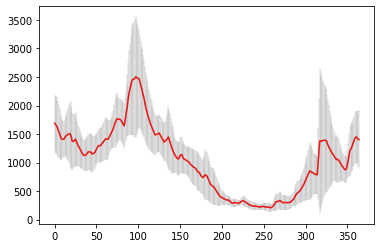

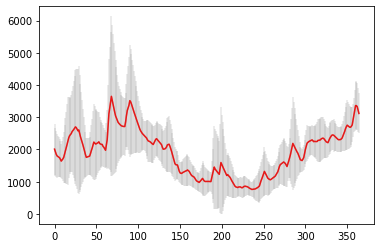

In [10]:
x = np.arange(0, 365, 1)
plt.errorbar(x, Q1_ave_baseflow, yerr=(Q1_min_baseflow, Q1_max_baseflow), color='gray', alpha = 0.2)
plt.plot(x, Q1_ave_baseflow, color='red')
plt.show()

plt.errorbar(x, Q4_ave_baseflow, yerr=(Q4_min_baseflow, Q4_max_baseflow), color='gray', alpha = 0.2)
plt.plot(x, Q4_ave_baseflow, color='red')
plt.show()

In [11]:
year_markers = [90, 91, 92, 92]
print(sum(year_markers))
def residual_dist(quartile):
    residuals = [[], [], [], []]
    for year_data in quartile:
        d = 0
        for i in range(len(year_markers)):
            for j in range(year_markers[i]):
                r = year_data[2][d] - year_data[3][d]
                if r > 0.0:
                    residuals[i].append(r)
                d += 1
    return np.array(residuals)

def maxima_dist(quartile):
    maxima = [0, 0, 0, 0]
    for year_data in quartile:
        d = 0
        for i in range(len(year_markers)):
            for j in range(year_markers[i]):
                if d == 0 or d == 364:
                    d += 1
                    continue
                if year_data[2][d] >= year_data[2][d - 1] and year_data[2][d] >= year_data[2][d + 1]:
                    maxima[i] += 1
                d += 1
    return np.array(maxima)

365


In [12]:
Q1_residuals = residual_dist(Q1)
Q4_residuals = residual_dist(Q4)

Q1_maxima_count = maxima_dist(Q1)
Q4_maxima_count = maxima_dist(Q4)

print(Q1_maxima_count, Q4_maxima_count)

[111 105 147 118] [100  98 110  94]


In [13]:
# sns.kdeplot(Q1_residuals)
# for q in range(len(Q1_residuals)):
#     print(len(Q1_residuals[q]) / 8 / year_markers[q])

In [14]:
# sns.kdeplot(Q4_residuals)
# for q in range(len(Q4_residuals)):
#     print(len(Q4_residuals[q]) / 8 / year_markers[q])

In [15]:
def timeseries(n, s):
    vals = list(np.random.normal(0.0, 0.25, n))
    s_half = s //  2

    # first pass
    mid_vals = []
    rolling_first = [vals[i - s_half] for i in range(n)]
    rolling = sum(rolling_first)
    for i in range(0, n):
        mid_vals.append(rolling / s)
        rolling += vals[(i + s_half + 2 * n) % n] - vals[(i - s_half + 2 * n) % n]
    fv_min = min(mid_vals)
    fv_max = max(mid_vals)
    fv_range = fv_max - fv_min
    for i in range(0, n):
        # final_vals[i] = final_vals[i]  / fv_max
        mid_vals[i] = ((mid_vals[i] - fv_min) / fv_range * 2) - 1.0

    # second pass
    final_vals = []
    rolling_second = [mid_vals[i - s_half] for i in range(n)]
    rolling = sum(rolling_second)
    for i in range(0, n):
        final_vals.append(rolling / s)
        rolling += mid_vals[(i + s_half + 2 * n) % n] - mid_vals[(i - s_half + 2 * n) % n]

    fv_min = min(final_vals)
    fv_max = max(final_vals)
    fv_range = fv_max - fv_min
    for i in range(0, n):
        final_vals[i] = (final_vals[i] - fv_min) / fv_range * 2.0 - 1.0

    return final_vals

# x = np.arange(0, 365, 1)
# ts = timeseries(365, 35)
# print(min(ts), max(ts))
# plt.plot(x, ts)

In [16]:
def gen_data(baseflow, min_flow, max_flow, event_count, noise):
    new_data = []
    d = 0
    ts = timeseries(365, 35)
    for i in range(len(year_markers)):
        for j in range(year_markers[i]):
            new_val = baseflow[d]
            if ts[d] < 0.0:
                new_val += min_flow[d] * ts[d]
            if ts[d] > 0.0:
                new_val += max_flow[d] * ts[d]
            if new_val < 0.0:
                new_val = 0.0
            new_data.append(new_val)
            d += 1
    # new_data = [0] * 365
    # add rain events
    d = 0
    for i in range(len(year_markers)):
        rain_prob = event_count[i] / 8 / year_markers[i]
        for j in range(year_markers[i]):
            r = random.random()
            if r < rain_prob:
                # rain event
                new_data[d] = new_data[d] + noise[i][random.randint(0, len(noise[i]) - 1)]

                # smooth dropoff from rain event
                rolling_window = sum(new_data[d:d+3])
                for k in range(2):
                    if d + 4 + k > 364:
                        break
                    new_data[d + k + 1] = rolling_window / 3
                    rolling_window += new_data[d + 3 + 1 + k] - new_data[d + k]
            d += 1

    return new_data

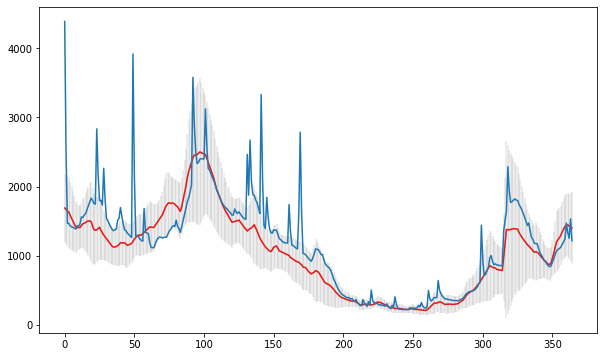

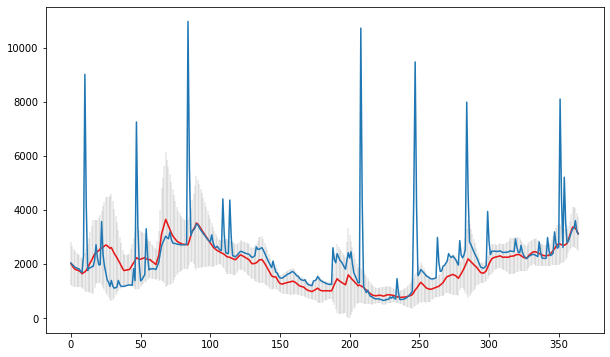

427294.0130026616 815008.0935458087


In [17]:
plt.rcParams['figure.figsize'] = [10, 6] 
x = np.arange(0, 365, 1)

plt.errorbar(x, Q1_ave_baseflow, yerr=(Q1_min_baseflow, Q1_max_baseflow), color='gray', alpha = 0.2)
plt.plot(x, Q1_ave_baseflow, color='red')

Q1_new = gen_data(Q1_ave_baseflow, Q1_min_baseflow, Q1_max_baseflow, Q1_maxima_count, Q1_residuals)
plt.plot(x, Q1_new)
plt.show()


plt.errorbar(x, Q4_ave_baseflow, yerr=(Q4_min_baseflow, Q4_max_baseflow), color='gray', alpha = 0.2)
plt.plot(x, Q4_ave_baseflow, color='red')
Q4_new = gen_data(Q4_ave_baseflow, Q4_min_baseflow, Q4_max_baseflow, Q4_maxima_count, Q4_residuals)
plt.plot(x, Q4_new)
plt.show()

print(sum(Q1_new), sum(Q4_new))

In [18]:
gauge_df = pd.read_csv('gauge_height.csv')
gauge_list = [i[0].split("    ") for i in np.array(gauge_df)]

short_gauge = np.array([[i[3].split(" ")[0], float(i[6].split("   ")[0])] for i in gauge_list])
gauge_dates = np.unique(np.array(short_gauge)[:,0])
short_gauge

array([['2010-01-01', '4.08'],
       ['2010-01-01', '4.08'],
       ['2010-01-01', '4.08'],
       ...,
       ['2020-01-02', '5.01'],
       ['2020-01-02', '5.04'],
       ['2020-01-02', '5.02']], dtype='<U10')

[63.68313784  2.37765023 -1.34000555]


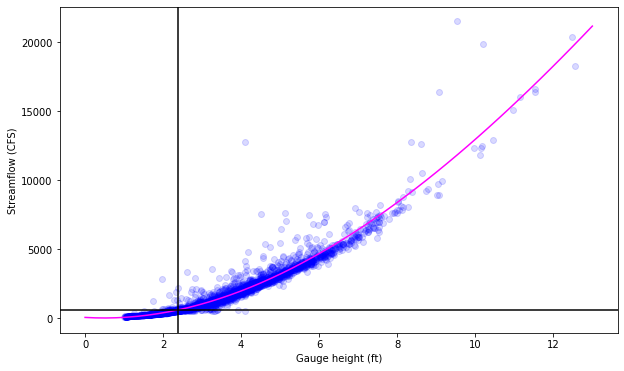

In [19]:
unique_dates, indices = np.unique(short_gauge[:,0], return_index=True)
short_gauge = short_gauge[indices]

CFS_dates = [str(i).split(' ')[0] for i in Dates]
dates_and_CFS = [[CFS_dates[i], CFS[i]] for i in range(len(CFS))]

dates_plot = []
CFS_plot = []
for i in dates_and_CFS:
    if i[0] in short_gauge[:,0]:
        dates_plot.append(i[0])
        CFS_plot.append(i[1])

gauge_plot = []
for i in short_gauge:
    if i[0] in dates_plot:
        gauge_plot.append(float(i[1]))
        
plt.scatter(gauge_plot, CFS_plot, color = 'b', alpha = 0.15)

xp = np.linspace(0, 13)
params = np.polyfit(gauge_plot, CFS_plot, 3)
p = np.poly1d(params)
plt.plot(xp, p(xp), color = 'fuchsia')

plt.axhline(y = 600, color = 'k')

y0 = 600
x0 = (p - y0).roots
print(x0)
plt.axvline(x = x0[1], color = 'k')

plt.xlabel('Gauge height (ft)')
plt.ylabel('Streamflow (CFS)')
plt.show()

251.1181315532237
9189.37415303833


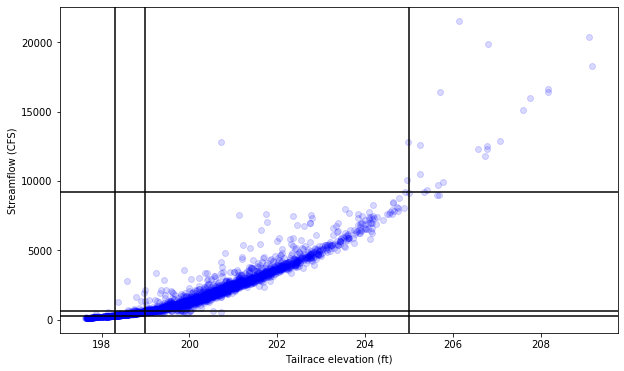

In [20]:
# No pumps may be operated below CFS_min
# One pump may be operated between CFS_min and 600
# Both pumps may be operated above 600 CFS
# No pumps may be operated above CFS_max

tail_gauge_offset = 199 - np.round(x0[1], 2)
gauge_plot_tail = np.array(gauge_plot) + tail_gauge_offset
plt.scatter(gauge_plot_tail, CFS_plot, color = 'b', alpha = 0.15)

plt.axvline(x = 199, color = 'k')
plt.axhline(y = 600, color = 'k')

plt.axvline(x = 198.3, color = 'k')
CFS_min = p(x0[1] - (199 - 198.3))
print(CFS_min)
plt.axhline(y = CFS_min, color = 'k')

plt.axvline(x = 205, color = 'k')
CFS_max = p(x0[1] - (199 - 205))
print(CFS_max)
plt.axhline(y = CFS_max, color = 'k')

plt.xlabel('Tailrace elevation (ft)')
plt.ylabel('Streamflow (CFS)')
plt.show()

In [21]:
prices_df = pd.read_csv('daily_average_prices.csv')
daily_price = np.array(prices_df["LMP average day-head price"])

In [33]:
prices_df

Day of the year  LMP average day-head price  \
0                  1                  100.959167   
1                  2                   61.168880   
2                  3                   73.453947   
3                  4                   33.502516   
4                  5                   19.622730   
5                  6                   96.086256   
6                  7                   58.951894   
7                  8                   53.586505   
8                  9                   23.139250   
9                 10                  143.956022   
10                11                   45.888046   
11                12                   49.542263   
12                13                  112.863756   
13                14                  135.919268   
14                15                   33.034027   
15                16                   64.350743   
16                17                   49.550221   
17                18                   63.863302   
18                19                  108.745185   
19                20                  114.023167   
20                21                   82.708600   
21                22                   80.171361   
22                23                   83.627003   
23                24                   89.993620   
24                25                  103.761714   
25                26                   93.839916   
26                27                   59.952313   
27                28                   45.344932   
28                29                   87.478480   
29                30                  104.830167   
..               ...                         ...   
335              336                   63.779131   
336              337                   56.854123   
337              338                   51.990311   
338              339                   56.635429   
339              340                   50.646237   
340              341                   31.975872   
341              342                   74.176286   
342              343                   66.768677   
343              344                   62.651824   
344              345                   41.642165   
345              346                   43.089021   
346              347                   52.301901   
347              348                   35.655161   
348              349                   57.643315   
349              350                   51.224800   
350              351                   82.073578   
351              352                   84.060575   
352              353                   54.503822   
353              354                   61.974919   
354              355                   52.483468   
355              356                   38.969122   
356              357                   59.759455   
357              358                   73.919634   
358              359                   55.312551   
359              360                   79.385372   
360              361                   55.147096   
361              362                   33.548803   
362              363                   49.564915   
363              364                   65.280632   
364              365                   53.563611   

     Monthly Average Value (2016-2021)  
0                            65.042857  
1                            65.042857  
2                            65.042857  
3                            65.042857  
4                            65.042857  
5                            65.042857  
6                            65.042857  
7                            65.042857  
8                            65.042857  
9                            65.042857  
10                           65.042857  
11                           65.042857  
12                           65.042857  
13                           65.042857  
14                           65.042857  
15                           65.042857  
16                           65.042857  
17                           65.042857  
1

In [22]:
# 250 * 60 * 60 : cubic feet pumped per hour
# 2.4394e8 : square feet surface area of lake

def function(params):
    river_CFS = Q1_new
    lake_level = 428.25
    running_profit = 0

    pump_time = [params[i] for i in range(365)]
    
    for i in range(365):
        new_level = lake_level + (250 * 60 * 60) / 2.4394e8 * pump_time[i]
        if (new_level < 427 or new_level > 429.5) or (river_CFS[i] < 251.12 and pump_time[i] > 0) or (river_CFS[i] > 9189.37 and pump_time[i] < 0):
            running_profit = 0
            return running_profit
        
        lake_level = new_level
        running_profit = running_profit - daily_price[i] * 13 * pump_time[i]
    
    print(running_profit)
    return -1 * running_profit

In [24]:
function(res.x)

175538.6876125399


-175538.6876125399

In [25]:
sum(res.x > 0)

12

In [26]:
# lake_level = 428 : 

# l-bfgs-b : 150000
# tnc : 180000 ***
# cobyla : 150000 ****
# slsqp : 140000
# trust-constr : 170000 ***

In [27]:
hold_df = pd.read_csv('year_of_LMP_2.csv')
on_off_diff = np.array(hold_df['allyearHOLD'])
hold_revenues = on_off_diff * 13 * 8

In [28]:
# 250 * 60 * 60 : cubic feet pumped per hour
# 2.4394e8 : square feet surface area of lake

def function1(params):
    river_CFS = Q1_new
    lake_level = 428.25
    running_profit = 0

    pump_time = [params[i] for i in range(365)]
    
    for i in range(365):
        new_level = lake_level + (250 * 60 * 60) / 2.4394e8 * pump_time[i]
        if (new_level < 427 or new_level > 429.5) or (river_CFS[i] < 251.12 and pump_time[i] > 0) or (river_CFS[i] > 9189.37 and pump_time[i] < 0):
            running_profit = 0
            return running_profit
        
        daily_revenue = -1 * daily_price[i] * 13 * pump_time[i]
        
        if 0 < daily_revenue < hold_revenues[i]:
            running_profit = running_profit + hold_revenues[i]
        else:
            running_profit = running_profit + daily_revenue
            lake_level = new_level
    
    print(running_profit, lake_level)
    return -1 * running_profit

In [29]:
x0 = np.zeros(365)
bnds = [(-24, 24)] * 365

res = opt.minimize(function1, x0, method='cobyla', bounds = bnds)
# print(res)
res.x

0.0 428.25
-1312.4691736 428.2536894318275
-795.19544624 428.2536894318275
-954.9013048899999 428.2536894318275
-435.53270475 428.2536894318275
-255.09549195 428.2536894318275
-1249.12132488 428.2536894318275
-766.3746259 428.2536894318275
-696.62456084 428.2536894318275
-300.81025351 428.2536894318275
-1871.4282859999998 428.2536894318275
-596.54459527 428.2536894318275
-644.0494174400001 428.2536894318275
-1467.2288345 428.2536894318275
-1766.9504892000002 428.2536894318275
-429.44235242999997 428.2536894318275
-836.5596560099999 428.2536894318275
-644.15287911 428.2536894318275
-830.22292184 428.2536894318275
-1413.6874063 428.2536894318275
-1482.3011658 428.2536894318275
-1075.21179831 428.2536894318275
-1042.22768988 428.2536894318275
-1087.15103822 428.2536894318275
-1169.91705363 428.2536894318275
-1348.9022872 428.2536894318275
-1219.91890605 428.2536894318275
-779.38006978 428.2536894318275
-589.48411483 428.2536894318275
-1137.22024104 428.2536894318275
-1362.7921736 428.2536

-295.72383373 428.2536894318275
-576.10812142 428.2536894318275
-630.99745085 428.2536894318275
-525.7039086000001 428.2536894318275
-604.9285734700001 428.2536894318275
-591.6746262700001 428.2536894318275
-464.25023905 428.2536894318275
-539.00418676 428.2536894318275
-308.86581868999997 428.2536894318275
-578.75532871 428.2536894318275
-352.38271705 428.2536894318275
-852.16332448 428.2536894318275
-389.09398281 428.2536894318275
-473.04396672 428.2536894318275
-402.81060287 428.2536894318275
-428.99098619 428.2536894318275
-469.78660781 428.2536894318275
-625.57784588 428.2536894318275
-348.492846 428.2536894318275
-504.21398066 428.2536894318275
-719.82080391 428.2536894318275
-566.83845218 428.2536894318275
-608.80519193 428.2536894318275
-336.79808006 428.2536894318275
-462.89621664 428.2536894318275
-342.95389231999997 428.2536894318275
-469.78921678 428.2536894318275
-651.5816801000001 428.2536894318275
-499.37063072 428.2536894318275
-342.50978918 428.2536894318275
-359.39287

353029.8248627115 428.2174189401082
351626.71640503826 428.2173914716651
353029.89113413985 428.2174187017387
353036.59568639996 428.2173892749131
353029.97042071004 428.21741840852985
351796.82679087674 428.21740676865574
353030.11260032444 428.217417875728
353036.5960556723 428.21738927295576
353030.26498134993 428.21741730706987
351228.8686257244 428.2173971185559
352624.13754296105 428.2174181137159
351358.1915412811 428.2174027410447
352624.4108595542 428.2174170320884
352273.2515820645 428.2174079845919
352624.49661795876 428.2174167075558
351754.20525594545 428.21739764187646
352624.59425522265 428.2174163367414
352060.4586556019 428.217397125235
352624.5656204787 428.21741647477
351724.04984289204 428.2173988972791
352624.65990615875 428.21741611813786
352607.5363915965 428.21740375030276
352675.3193477332 428.2154663359247
351666.6327332989 428.2174085963354
352624.7013990943 428.2174159988772
352257.05974548904 428.2174035489899
352624.78173048963 428.2174157006917
352470.731

351327.15470196476 428.21625660212
346603.3096793578 428.21765998030514
351646.49612307135 428.216262199527
347128.6949757098 428.2176686927307
351957.4147997051 428.2162654275786
347550.7543270271 428.21767421179317
352597.9605987637 428.2162973869855
347991.39422862546 428.2177095394295
352414.9375022467 428.2163514147272
351589.64760788536 428.2141366231621
353474.07547605014 428.215343643791
349636.0288775164 428.2154462733426
352464.41673725966 428.2156774371067
349640.7736808072 428.2154343562574
345342.45784382016 428.2164613354354
353701.7087090332 428.21527115178816
353670.8374500025 428.2153492733591
353684.7290925463 428.2153176693331
353812.41253945953 428.21440002373896
353792.08944666473 428.21444728932613
354048.59328365163 428.2113523061217
352794.31402332004 428.21145895250237
352707.4641558053 428.2114567679421
354024.74567164993 428.2114110448473
354035.1612243004 428.2113822936544
354026.581135614 428.2114114048159
354004.9018060425 428.2114547405739
353032.47951077

array([-5.96779493e-01, -2.66739385e-01, -2.74124817e-01, -1.57938331e-01,
       -2.68724702e-01, -3.27577633e-01, -9.05814129e-01, -3.70081544e-01,
       -1.38697412e-01, -3.56574952e+00, -1.07527294e-03, -3.62897310e-01,
       -1.38791023e+00, -1.59542154e-01, -1.54506817e-01, -2.29781393e-01,
       -1.03260168e-02, -1.53116445e-01, -1.52579757e-01, -2.30999900e-01,
       -5.14927602e-01, -6.90542106e-01, -3.32070008e-01, -9.38917416e-01,
       -1.09316435e+00, -7.66475319e-01, -2.74507940e-01, -1.79902003e-01,
       -3.69829107e-01, -6.81447529e-01, -3.96636925e-01, -8.30357216e-03,
       -3.71783445e-01, -3.59770574e-01, -1.74886928e-01, -2.70453293e-01,
       -3.57094312e-02, -2.31797832e-01, -1.44710480e-01, -1.18643701e-02,
       -2.50487695e-01, -3.68384717e-01, -1.37242828e-01, -2.88521567e-01,
       -2.18529651e-02, -3.56867276e-01, -1.45170880e-01, -2.65727825e-01,
       -1.04852348e-02, -2.08988903e-02, -3.60378797e-01, -2.97287036e-01,
       -2.63730076e-02, -

In [31]:
sum(-1 * daily_price * 13 * res.x < hold_revenues)

351

In [32]:
sum(res.x > 0)

0